In [1]:
from requests import get
from bs4 import BeautifulSoup
import time
from time import sleep
import random
import pandas as pd
import re
import math
from json import loads
import json
from IPython.core.display import clear_output
import psycopg2

## Connect to PostgreSQL

In [2]:
# Update connection string information 
host = "gpu-dashboard.postgres.database.azure.com"
dbname = "postgres"
user = "seok0704@gpu-dashboard"
password = "djfgp2RM!"
sslmode = "require"
# Construct connection string
conn_string = "host={0} user={1} dbname={2} password={3} sslmode={4}".format(host, user, dbname, password, sslmode)
conn = psycopg2.connect(conn_string) 
print("Connection established")

Connection established


In [3]:
cursor = conn.cursor()

In [4]:
def connect_postgreSQL(conn_string):
    
    conn = psycopg2.connect(conn_string) 
    print("successfully Connected")
    
    return conn, conn.cursor()

In [5]:
def run_query(conn,query):
    
    return pd.read_sql(query, con=conn)

In [6]:
def insert(conn, cursor, insert_query):
    cursor.execute(insert_query)
    conn.commit()

# Create Tables

In [7]:
create_chipset_database = """
CREATE TABLE chipsets(
    chipset_id SERIAL PRIMARY KEY,
    chipset_name TEXT); 
"""

conn.cursor().execute(create_chipset_database)
conn.commit()

DuplicateTable: relation "chipsets" already exists


In [76]:
create_gpu_cards = """
CREATE TABLE gpu_info(
    card_id VARCHAR(250) PRIMARY KEY,
    name VARCHAR(250),
    chipset_id INTEGER,
    rating FLOAT,
    manufacturer VARCHAR(250),
    memory VARCHAR(50),
    core_clock VARCHAR(50),
    boost_clock VARCHAR(50),
    color VARCHAR(50),
    length VARCHAR(50),
    FOREIGN KEY(chipset_id) REFERENCES chipsets(chipset_id)
); 
"""

conn.cursor().execute(create_gpu_cards)
conn.commit()

In [73]:
create_card_prices = """
CREATE TABLE card_prices(
    card_id VARCHAR(250),
    datetime INT,
    merchant_name VARCHAR(250),
    price FLOAT,
    PRIMARY KEY(card_id, merchant_name, datetime),
    FOREIGN KEY(card_id) REFERENCES gpu_info(card_id)
    ); 
"""

conn.cursor().execute(create_card_prices)
conn.commit()

InFailedSqlTransaction: current transaction is aborted, commands ignored until end of transaction block


# Scrape Chipsets

In [9]:
def scrape_chipsets(conn_string='host=gpu-dashboard.postgres.database.azure.com user=seok0704@gpu-dashboard dbname=postgres password=djfgp2RM! sslmode=require'):
    
    conn, cursor = connect_postgreSQL(conn_string)
    
    response = get(url='https://pcpartpicker.com/products/video-card/')
    html_soup = BeautifulSoup(response.text, 'html.parser')
    
    
    for gpu_class in html_soup.find_all("li", {"class": "abbreviated_c"}):
        gpu = gpu_class.find('label').get_text()
                
        insert_query = "INSERT INTO chipsets(chipset_name) VALUES ('{}')".format(gpu)
        
        try:        
            insert(conn, cursor, insert_query)
        except Exception as e:
            conn.rollback()
            print("Fail to insert the chipset: {}".format(gpu))
            
    print("Chipset Data Uploaded")

# Scrape GPU Cards

In [10]:
def insert_card_info(card_id,html_soup,conn, cursor,chipset_data):
    
    chipset_exist = True
    
    def get_specs(specs_block, content):
        try:
            return specs_block.find(text=content).find_parent('h3').next_sibling.next_sibling.text.strip()
        except Exception as e:
            return 'null'
        
    name = html_soup.find('h1', class_='pageTitle').text
    
    try:
        rating = float(html_soup.find('ul', class_='product--rating list-unstyled').next_sibling.strip().split()[2])
    except Exception as e:
        rating = 'null'

    specs_block = html_soup.find('div', class_='block xs-hide md-block specs')
    
    
    chipset_name = get_specs(specs_block,'Chipset')
    
    try:
        chipset_id = chipset_data[chipset_data['chipset_name']==chipset_name]['chipset_id'].iloc[0]
        
        manufacturer = get_specs(specs_block,'Manufacturer')
        memory = get_specs(specs_block,'Memory')
        core_clock = get_specs(specs_block,'Core Clock')
        boost_clock = get_specs(specs_block,'Boost Clock')
        color = get_specs(specs_block,'Color')
        length = get_specs(specs_block,'Length')

        insert_query = '''
                INSERT INTO gpu_info(
                    card_id,
                    name,
                    chipset_id,
                    rating,
                    manufacturer,
                    memory,
                    core_clock,
                    boost_clock,
                    color,
                    length
                ) 
                VALUES ('{}', '{}', {}, {}, '{}', '{}','{}', '{}', '{}','{}')
                ON CONFLICT(card_id) DO NOTHING
            '''.format(card_id, name, chipset_id, rating, manufacturer, memory, core_clock, boost_clock, color, length)
        
    except Exception as e:
        print("Cannot find the chipset_id for card_id: {}".format(card_id))
        chipset_exist = False
        return chipset_exist
        
    try:        
        insert(conn, cursor, insert_query)
        
    except Exception as e:
        conn.rollback()
        print("Fail to insert the chipset: {}".format(card_id))
    
    return chipset_exist
        


In [11]:
def insert_price(card_id,html_soup,conn, cursor):        
    scripts = html_soup.findAll('script')
    
    for s in scripts:
        if "var chart_data = " in s.prettify():
            data = loads(s.prettify().split("var chart_data = ")[1].rsplit(';')[0])
        else:
            data = []
            
    if len(data) == 0:
        print("No price for {}".format(card_id))
        return 
    
    else:
        for merch in data:
            merchant_name = merch['label']
            
            for data_point in merch['data']:
                datetime = data_point[0]
                price = data_point[1]
                
                if datetime and price:
                    
                    insert_query = '''
                            INSERT INTO card_prices(
                                card_id,
                                datetime,
                                merchant_name,
                                price
                            ) 
                            VALUES ('{}', {}, '{}', {})
                        '''.format(card_id, int(datetime/1000), merchant_name, float(price/100))

                    try:        
                        insert(conn, cursor, insert_query)
                    except Exception as e:
                        conn.rollback()
                        print("Fail to insert the price for the card_id: {}".format(card_id))
                        

In [12]:
def scrape_card_info(conn_string):
    conn, cursor = connect_postgreSQL(conn_string)
    
    chipset_data = run_query(conn,("select * from chipsets"))
    
    curr_data = (run_query(conn,("select * from gpu_info")))
    
    if len(curr_data)>=0:
        chipset_data = chipset_data[~chipset_data['chipset_id'].isin(curr_data['chipset_id'].unique())]
    
    for chipset in chipset_data['chipset_name']:
        page = 1
        print("Working")
        print("----------------Working on chipset: {}------------".format(chipset))
        while True:
            sleep(10.0)
            card_ids = []
            
            headers = {'User-Agent': 'for personal project, contact:seok0704@gmail.com'}

            response = get(url='https://pcpartpicker.com/search/?q={}&page={}'.format(chipset,page),headers = headers)
            html_soup = BeautifulSoup(response.text, 'html.parser')
                
            gpu_id_htmls = html_soup.find_all("p", {"class": "search_results--link"})
            
            if len(gpu_id_htmls)==0:
                break
            
            else:
                for gpu_class in html_soup.find_all("p", {"class": "search_results--link"}):
                    gpu = gpu_class.find_all('a', href=True)
                    card_id = str(gpu[0]).split('/')[2]
                    card_ids.append(card_id)
                    
                for card_id in card_ids:
                    print("Inserting card ID: {} to the database".format(card_id))
                    sleep(10.0)
                    user_agent = random.choice(user_agent_list)
                    headers = {'User-Agent': user_agent}

                    response = get(url='https://pcpartpicker.com/product/{}/?history_days=365'.format(card_id),headers = headers)
                    html_soup = BeautifulSoup(response.text, 'html.parser')

                    chipset_exist = insert_card_info(card_id,html_soup,conn, cursor,chipset_data)
                    if chipset_exist:
                        insert_price(card_id,html_soup,conn, cursor)
                        
                page +=1


In [27]:
scrape_card_info(conn_string)

successfully Connected
Working
----------------Working on chipset: GeForce GTX 660------------
Inserting card ID: DGQypg to the database
No price for DGQypg
Inserting card ID: xc8Zxr to the database
No price for xc8Zxr
Inserting card ID: 9z4gXL to the database
No price for 9z4gXL
Inserting card ID: 8BCwrH to the database
No price for 8BCwrH
Inserting card ID: yjTmP6 to the database
No price for yjTmP6
Inserting card ID: Vz4gXL to the database
No price for Vz4gXL
Inserting card ID: dKw323 to the database
No price for dKw323
Inserting card ID: CGQypg to the database
No price for CGQypg
Inserting card ID: xMsKHx to the database
No price for xMsKHx
Inserting card ID: nBXfrH to the database
No price for nBXfrH
Inserting card ID: vJJwrH to the database
No price for vJJwrH
Inserting card ID: qDGkcf to the database
No price for qDGkcf
Inserting card ID: 2CTmP6 to the database
No price for 2CTmP6
Inserting card ID: vp6BD3 to the database


AttributeError: 'NoneType' object has no attribute 'text'

# Scrape Benchmark

In [206]:
create_benchmark = """
CREATE TABLE gpu_benchmark(
    chipset_id INTEGER PRIMARY KEY,
    msrp_price INTEGER,
    value_for_money INT,
    score INT,
    popularity float,
    FOREIGN KEY(chipset_id) REFERENCES chipsets(chipset_id)
); 
"""

conn.cursor().execute(create_benchmark)
conn.commit()

In [211]:
def scrape_benchmark(conn_string):
    conn, cursor = connect_postgreSQL(conn_string)
    chipset_data = run_query(conn,("select * from chipsets"))

    insert_query = '''
            INSERT INTO gpu_benchmark(
                chipset_id,
                msrp_price,
                value_for_money,
                score,
                popularity
            ) 
            VALUES ({}, {}, {}, {}, {})
            ON CONFLICT(chipset_id) DO NOTHING
            '''

    def get_chipset_id(chipset_name,chipset_data):
        
        chipset_name = chipset_name.split()[-2] + " " + chipset_name.split()[-1]
        return chipset_data[chipset_data['chipset_name'].str.lower().str.replace("[()\\s-]+", " ").str.contains(chipset_name.lower())]['chipset_id'].iloc[0]

    def get_content(row):
        chipset_name = row[0].find('a').text
        chipset_id = get_chipset_id(chipset_name,chipset_data)

        if row[1].text.strip() == 'n/a': 
            msrp_price = 'null' 
        else: 
            msrp_price = int(row[1].text.strip()[1:])    
            
        score = int(row[2].text.strip())
        
        if row[3].text.strip() == 'n/a':
            value_for_money = 'null'
        else: 
            value_for_money = int(row[3].text.strip())    
            
            
        popularity = float(row[4].text.strip())

        return chipset_id,msrp_price,value_for_money,score,popularity

    
    headers = {'User-Agent': 'for personal project, contact:seok0704@gmail.com'}

    response = get(url='https://benchmarks.ul.com/compare/best-gpus?amount=0&sortBy=SCORE&reverseOrder=true&types=DESKTOP&minRating=0',headers = headers)
    html_soup = BeautifulSoup(response.text, 'html.parser')   
    
    row_1 = html_soup.findChildren("td")[1:7]
    row_2 = html_soup.findChildren("td")[7:12]
    
    for row in [row_1,row_2]:
        chipset_id,msrp_price,value_for_money,score,popularity = get_content(row)
        insert(conn, cursor, insert_query.format(chipset_id,msrp_price,value_for_money,score,popularity))

    for row in html_soup.findChildren("tr")[3:]:
        print(row.find_all('td')[1:][0].find('a').text)
        try:
            row = row.find_all('td')[1:]
            chipset_id,msrp_price,value_for_money,score,popularity = get_content(row)       


            insert(conn, cursor, insert_query.format(chipset_id,msrp_price,value_for_money,score,popularity))
            print("Chipset_id: {} Success!",format(chipset_id))

        except Exception as e:
            
            print("chipset_name: {} Failed!",format(chipset_id))
        

In [239]:
get_benchmark_info = '''
        SELECT gb.*, c.chipset_name
        FROM gpu_benchmark gb
        INNER JOIN chipsets c ON
        c.chipset_id = gb.chipset_id
        '''


In [235]:
benchmark_per_chip

NameError: name 'benchmark_per_chip' is not defined

In [241]:
get_price = '''
        SELECT p.card_id, p.datetime, p.merchant_name, p.price, g.chipset_id, c.chipset_name
        FROM card_prices p
        INNER JOIN gpu_info g ON
        g.card_id = p.card_id
        INNER JOIN chipsets c ON
        c.chipset_id = g.chipset_id
        '''


In [246]:
benchmark_per_chip = run_query(conn, get_benchmark_info).sort_values(by=['score'], ascending=False)


In [258]:
benchmark_per_chip

,chipset_id,msrp_price,value_for_money,score,popularity,chipset_name
51,411,1499.0,13.0,19970,10.2,GeForce RTX 3090
50,410,1199.0,16.0,19573,0.5,GeForce RTX 3080 Ti
98,558,999.0,19.0,19167,4.2,Radeon RX 6900 XT
97,557,649.0,28.0,18217,3.6,Radeon RX 6800 XT
102,562,NaN,NaN,17904,0.0,RTX A6000
...,...,...,...,...,...,...
6,358,109.0,5.0,545,0.0,GeForce GTX 650
3,333,89.0,5.0,513,0.0,GeForce GT 740
2,332,59.0,5.0,299,0.0,GeForce GT 730
1,330,34.0,5.0,200,0.0,GeForce GT 710


In [259]:
top_6 = benchmark_per_chip['chipset_id'][:7]

In [270]:
df = run_query(conn,("select * from gpu_info"))

In [272]:
spec_per_card = run_query(conn, get_gpu_info)

In [276]:
df = spec_per_card[spec_per_card['chipset_id']==277]

In [279]:
df = df[['name','chipset_name','manufacturer','memory','core_clock','boost_clock','color','length','rating']]

In [ ]:
df.to_dict("rows")

In [281]:
df.to_dict("rows")

C:\Users\JC\anaconda3\lib\site-packages\pandas\core\frame.py:1554: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


[{'name': 'AMD FirePro 2270 512 MB Video Card',
  'chipset_name': 'FirePro 2270',
  'manufacturer': 'AMD',
  'memory': '0.5 GB',
  'core_clock': '600 MHz',
  'boost_clock': 'null',
  'color': 'Black / Red',
  'length': '170 mm',
  'rating': nan},
 {'name': 'ATI FirePro 2270 512 MB Video Card',
  'chipset_name': 'FirePro 2270',
  'manufacturer': 'ATI',
  'memory': '0.5 GB',
  'core_clock': '600 MHz',
  'boost_clock': 'null',
  'color': 'Black / Red',
  'length': '170 mm',
  'rating': nan},
 {'name': 'ATI FirePro 2270 512 MB Video Card',
  'chipset_name': 'FirePro 2270',
  'manufacturer': 'ATI',
  'memory': '0.5 GB',
  'core_clock': '600 MHz',
  'boost_clock': 'null',
  'color': 'Black / Red',
  'length': '170 mm',
  'rating': nan}]

In [269]:
get_gpu_info = '''
        SELECT g.*, c.chipset_name
        FROM gpu_info g
        INNER JOIN chipsets c ON
        c.chipset_id = g.chipset_id
        '''


In [266]:
df.to_dict('records')

[{'card_id': 'xbvZxr',
  'name': 'AMD FirePro 2270 512 MB Video Card',
  'chipset_id': 277,
  'rating': nan,
  'manufacturer': 'AMD',
  'memory': '0.5 GB',
  'core_clock': '600 MHz',
  'boost_clock': 'null',
  'color': 'Black / Red',
  'length': '170 mm'},
 {'card_id': 'CZL7YJ',
  'name': 'AMD FirePro 2460 512 MB Video Card',
  'chipset_id': 279,
  'rating': nan,
  'manufacturer': 'AMD',
  'memory': '0.5 GB',
  'core_clock': 'null',
  'boost_clock': 'null',
  'color': 'Black / Red',
  'length': 'null'},
 {'card_id': 'rYJkcf',
  'name': 'AMD FirePro S7000 4 GB Video Card',
  'chipset_id': 282,
  'rating': nan,
  'manufacturer': 'AMD',
  'memory': '4 GB',
  'core_clock': '950 MHz',
  'boost_clock': 'null',
  'color': 'Black / Silver',
  'length': '292 mm'},
 {'card_id': 'DQ7CmG',
  'name': 'AMD FirePro V7900 SDI 2 GB Video Card',
  'chipset_id': 295,
  'rating': nan,
  'manufacturer': 'AMD',
  'memory': '2 GB',
  'core_clock': '725 MHz',
  'boost_clock': 'null',
  'color': 'Black / Red',

In [248]:
top_6

51     411
50     410
98     558
97     557
102    562
49     408
96     556
Name: chipset_id, dtype: int64

In [243]:
xx = run_query(conn, get_price)

In [252]:
import matplotlib.pyplot as plt


In [257]:
xx[xx['chipset_id']==557][:50]

,card_id,datetime,merchant_name,price,chipset_id,chipset_name
3234,XPjNnQ,1606322891,Newegg,809.98,557,Radeon RX 6800 XT
3235,XPjNnQ,1606501017,Newegg,809.98,557,Radeon RX 6800 XT
3236,XPjNnQ,1606874447,Newegg,799.99,557,Radeon RX 6800 XT
3237,XPjNnQ,1607382794,Newegg,799.99,557,Radeon RX 6800 XT
3238,XPjNnQ,1607403692,Newegg,799.99,557,Radeon RX 6800 XT
3239,XPjNnQ,1608345925,Newegg,799.99,557,Radeon RX 6800 XT
3240,XPjNnQ,1608603529,Newegg,799.99,557,Radeon RX 6800 XT
3241,XPjNnQ,1608778656,Newegg,799.99,557,Radeon RX 6800 XT
3242,XPjNnQ,1609293675,Newegg,799.99,557,Radeon RX 6800 XT
3243,XPjNnQ,1609813647,Newegg,799.99,557,Radeon RX 6800 XT


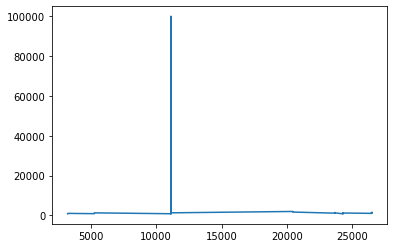

In [253]:
plt.plot(xx[xx['chipset_id']==557]['price'])

In [238]:
list(run_query(conn, get_benchmark_info).sort_values(by=['score'], ascending=False)[:6]['chipset_id'])


[411, 410, 558, 557, 562, 408]

In [219]:
run_query(conn, ('select * from chipsets'))[100:150]

,chipset_id,chipset_name
100,375,GeForce GTX 960
101,376,GeForce GTX 970
102,377,GeForce GTX 980
103,378,GeForce GTX 980 Ti
104,379,GeForce GTX 1050
105,380,GeForce GTX 1050 Ti
106,381,GeForce GTX 1060 3GB
107,382,GeForce GTX 1060 6GB
108,383,GeForce GTX 1070
109,384,GeForce GTX 1070 Ti


In [214]:
run_query(conn, ('select * from gpu_benchmark'))

,chipset_id,msrp_price,value_for_money,score,popularity
0,411,1499.0,13.0,19970,10.2
1,410,1199.0,16.0,19573,0.5
2,558,999.0,19.0,19167,4.2
3,557,649.0,28.0,18217,3.6
4,562,NaN,NaN,17904,0.0
...,...,...,...,...,...
103,333,89.0,5.0,513,0.0
104,332,59.0,5.0,299,0.0
105,330,34.0,5.0,200,0.0
106,328,99.0,1.0,166,0.0


In [213]:
scrape_benchmark(conn_string)

successfully Connected


C:\Users\JC\anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.


AMD Radeon 6900 XT
Chipset_id: {} Success! 558
AMD Radeon RX 6800 XT
Chipset_id: {} Success! 557
NVIDIA Quadro RTX A6000
Chipset_id: {} Success! 562
NVIDIA GeForce RTX 3080
Chipset_id: {} Success! 408
AMD Radeon RX 6800
Chipset_id: {} Success! 556
NVIDIA Titan RTX
Chipset_id: {} Success! 563
NVIDIA GeForce RTX 2080 Ti
Chipset_id: {} Success! 403
NVIDIA GeForce RTX 3070 Ti
Chipset_id: {} Success! 407
NVIDIA Quadro RTX 6000
Chipset_id: {} Success! 453
NVIDIA GeForce RTX 3070
Chipset_id: {} Success! 406
NVIDIA Titan V
Chipset_id: {} Success! 564
AMD Radeon RX 6700 XT
Chipset_id: {} Success! 555
NVIDIA GeForce RTX 3060 Ti
Chipset_id: {} Success! 405
NVIDIA GeForce RTX 2080 SUPER
Chipset_id: {} Success! 402
NVIDIA GeForce RTX 2080
Chipset_id: {} Success! 401
NVIDIA Quadro RTX 5000
Chipset_id: {} Success! 452
NVIDIA Titan Xp
Chipset_id: {} Success! 566
NVIDIA GeForce RTX 2070 SUPER
Chipset_id: {} Success! 400
NVIDIA Titan Xp Collector's Edition
chipset_name: {} Failed! 400
NVIDIA GeForce GTX